In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [9]:
%run ts_lib
%run ts_ml
%run ts_validation

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0



In [10]:
data_tcs = pd.read_csv('data/TCS_20200303.csv', index_col=0, parse_dates=True)
data_tcs = data_tcs.loc[~data_tcs.index.duplicated(), :] #.asfreq('B')

In [11]:
train_tcs = data_tcs.loc[data_tcs.index < '2016', 'Close'].diff().dropna()
val_tcs = data_tcs.loc[(data_tcs.index >= '2016') & (data_tcs.index < '2018'), 'Close'].diff().dropna()
test_tcs = data_tcs.loc[data_tcs.index >= '2018', 'Close'].diff().dropna()

In [30]:
for pred_window in [30, 100, 250]:
    val_X = get_rolling_windows(val_tcs, pred_window + 1)
    val_X, val_Y = val_X[:, :-1], val_X[:, -1].reshape((-1, 1))

    print(pred_window, np.mean(np.square(0 - val_Y)))

30 1094.1609967672412
100 1084.7510406091371
250 1001.2030122950817


In [46]:
for pred_window in [30, 100, 250]:
    train_X = get_rolling_windows(train_tcs, pred_window + 1)
    train_X, train_Y = train_X[:, :-1], train_X[:, -1].reshape((-1, 1))
    val_X = get_rolling_windows(val_tcs, pred_window + 1)
    val_X, val_Y = val_X[:, :-1], val_X[:, -1].reshape((-1, 1))

    print(pred_window, np.mean(np.square(np.median(train_Y) - val_Y)))

30 1093.4589224137928
100 1084.6665228426396
250 1000.0005225409835


In [48]:
for pred_window in [30, 100, 250]:
    val_X = get_rolling_windows(val_tcs, pred_window + 1)
    val_X, val_Y = val_X[:, :-1], val_X[:, -1].reshape((-1, 1))

    print(pred_window, np.mean(np.square(np.mean(val_Y) - val_Y)))

30 1093.29397089356
100 1084.6391384730348
250 998.9431654797097


In [12]:
pred_window = 100
train_X = get_rolling_windows(train_tcs, pred_window + 1)
train_X, train_Y = train_X[:, :-1], train_X[:, -1].reshape((-1, 1))
val_X = get_rolling_windows(val_tcs, pred_window + 1)
val_X, val_Y = val_X[:, :-1], val_X[:, -1].reshape((-1, 1))

In [13]:
sc = StandardScaler1D()
sc.fit(train_tcs)
train_X_sc = sc.transform(train_X)
train_Y_sc = sc.transform(train_Y)
val_X_sc = sc.transform(val_X)
val_Y_sc = sc.transform(val_Y)

In [14]:
ffn_factory = FFNModelFactory(seed=987654,
                              fixed_model_params={'n_input': 100,
                                                  'n_output': 1},
                              fixed_hidden_layer_params={})

In [15]:
nn_model = ffn_factory.build_model({'hidden_units': 20,
                                    'hidden_dropout': 0.2,
                                    'hidden_l2': 500.0,
                                    'output_l2': 20.0})
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,041
Trainable params: 2,041
Non-trainable params: 0
_________________________________________________________________


In [16]:
nn_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y))

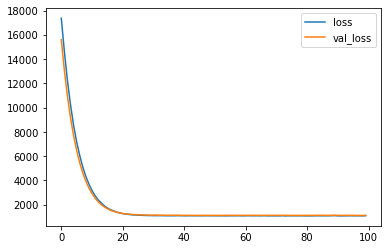

In [17]:
nn_model.plot_history()

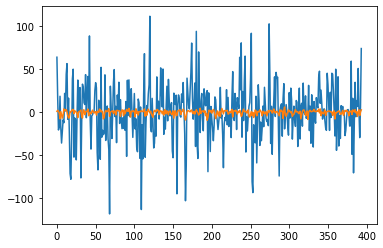

In [18]:
pd.Series(val_Y.flatten()).plot()
pd.Series(nn_model.predict(val_X).flatten()).plot()

In [19]:
print(np.mean(np.square(0 - val_Y)))
nn_model.mse(val_X, val_Y)

1084.7510406091371


1072.8124858807432

In [79]:
nn_model.fit(x=train_X_sc, y=train_Y_sc, validation_data=(val_X_sc, val_Y_sc))

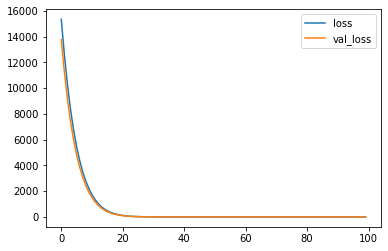

In [80]:
nn_model.plot_history()

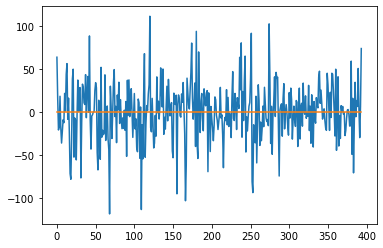

In [81]:
pd.Series(val_Y.flatten()).plot()
pd.Series(nn_model.predict(val_X).flatten()).plot()

In [82]:
print(np.mean(np.square(0 - val_Y)))
nn_model.mse(val_X, val_Y)

1084.7510406091371


1084.7525928576902

In [ ]:
cnn_model = CNNModel(n_input=10, n_output=1, seed=987654,
                        hidden_layer_properties={'filters': 10, 
                                                 'kernel_size': 3, 
                                                 'l2': 200.4, 
                                                 'dropout': 0.6,
                                                 'pool_size': 4},
                       output_layer_properties={'l2': 700.0, 'dropout': 0.2})
cnn_model.build_model() #loss=signed_mse(0.0))
cnn_model.summary()

In [12]:
cnn_factory = CNNModelFactory(seed=987654,
                              fixed_model_params={'n_input': 10,
                                                  'n_output': 1},
                              fixed_hidden_layer_params={'filters': 10,
                                                         'kernel_size': 3,
                                                         'pool_size': 4})

In [13]:
cnn_model = cnn_factory.build_model({'conv_l2': 200.4,
                                     'conv_dropout': 0.6,
                                     'output_dropout': 0.2,
                                     'output_l2': 700.0})
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 10)             40        
_________________________________________________________________
average_pooling1d (AveragePo (None, 2, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [14]:
cnn_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y))

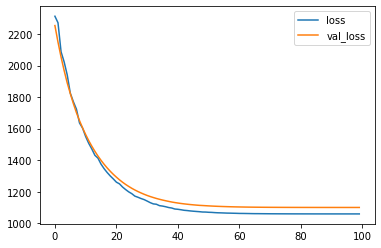

In [15]:
cnn_model.plot_history()

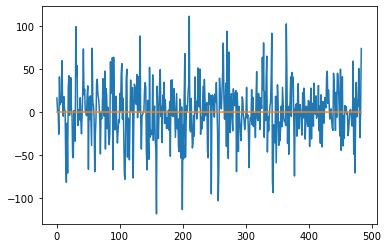

In [16]:
pd.Series(val_Y.flatten()).plot()
pd.Series(cnn_model.predict(val_X).flatten()).plot()

In [17]:
print(np.mean(np.square(0 - val_Y)))
cnn_model.mse(val_X, val_Y)

1100.8604648760327


1100.4283134765572

In [ ]:
lstm_model = LSTMModel(n_input=10, n_output=1, seed=987654,
                       hidden_layer_properties={'units': 20,
                                                'return_sequences': True,
                                                'kernel_dropout': 0.4,
                                                'recurrent_dropout': 0.3,
                                                'recurrent_l1': 700.0})
lstm_model.build_model() #loss=signed_mse(0.0))
lstm_model.summary()

In [ ]:
lstm_factory = LSTMModelFactory(seed=987654,
                                fixed_model_params={'n_input': 10,
                                                    'n_output': 1},
                                fixed_hidden_layer_params={'units': 20})

In [ ]:
lstm_model = lstm_factory.build_model({'kernel_dropout': 0.4,
                                       'recurrent_dropout': 0.3,
                                       'recurrent_l1': 700.0})
lstm_model.summary()

In [ ]:
lstm_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y))

In [ ]:
lstm_model.plot_history()

In [ ]:
pd.Series(val_Y.flatten()).plot()
pd.Series(lstm_model.predict(val_X).flatten()).plot()

In [ ]:
print(np.mean(np.square(0 - val_Y)))
lstm_model.mse(val_X, val_Y)

In [ ]:
print(np.mean(np.square(0 - val_Y)))
lstm_model.mse(val_X, val_Y)

In [ ]:
convlstm_model = ConvLSTMModel(n_input=10, n_output=1, seed=987654,
                               conv_layer_properties={'filters': 30,
                                                      'kernel_size': 3,
                                                      'padding': 'valid',
                                                      'l2': 300.0, 'dropout': 0.1},
                               lstm_layer_properties={'units': 50,
                                                      'return_sequences': True,
                                                      'kernel_dropout': 0.3,
                                                      'recurrent_l2': 600.0},
                               output_layer_properties={'dropout': 0.1})

convlstm_model.build_model() #loss=signed_mse(0.0))
convlstm_model.summary()

In [ ]:
convlstm_factory = ConvLSTMModelFactory(seed=987654,
                                        fixed_model_params={'n_input': 10,
                                                            'n_output': 1},
                                        fixed_conv_params={'filters': 30,
                                                           'kernel_size': 3},
                                        fixed_lstm_params={'units': 50})

In [ ]:
convlstm_model = convlstm_factory.build_model({'conv_l2': 300.0,
                                               'conv_dropout': 0.1,
                                               'kernel_dropout': 0.3,
                                               'recurrent_l2': 600.0,
                                               'output_droput': 0.1})
convlstm_model.summary()

In [ ]:
convlstm_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y))

In [ ]:
convlstm_model.plot_history()

In [ ]:
pd.Series(val_Y.flatten()).plot()
pd.Series(convlstm_model.predict(val_X).flatten()).plot()

In [ ]:
print(np.mean(np.square(0 - val_Y)))
convlstm_model.mse(val_X, val_Y)

In [ ]:
print(np.mean(np.square(0 - val_Y)))
convlstm_model.mse(val_X, val_Y)

In [ ]:
clstm_model = tsCLSTM(n_input=10, n_output=1,
                      cnn_properties={'filters': 30,
                                      'kernel_size': 3,
                                      'same_padding': False,
                                      'l1': 0.0, 'l2': 300.0,
                                      'dropout': 0.1,
                                      'pool_size': 1},
                      lstm_properties={'units': 50,
                                       'return_sequences': True,
                                       'kernel_dropout': 0.3, 'recurrent_dropout': 0.0,
                                       'kernel_l1': 0.0, 'kernel_l2': 0.0,
                                       'recurrent_l1': 0.0, 'recurrent_l2': 600.0},
                      dropout=0.1)

clstm_model.summary()
clstm_optimizer=tf.keras.optimizers.Adam()
clstm_model.compile(optimizer=lstm_optimizer, loss='mse')

In [ ]:
np.random.seed(clstm_model.seed)
tf.random.set_seed(clstm_model.seed)
clstm_hist = clstm_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y), 
                             batch_size=200, epochs=100, verbose=0)

In [ ]:
pd.DataFrame.from_dict(clstm_hist.history).plot()

In [ ]:
pd.Series(val_Y.flatten()).plot()
pd.Series(clstm_model.predict(val_X).flatten()).plot()

In [ ]:
print(np.mean(np.square(0 - val_Y)))
np.mean(np.square(clstm_model.predict(val_X) - val_Y))

In [ ]:
tf.keras.backend.clear_session()

window = 10
cr_seed = 987654
cr_dropout = 0.0

cr_initializer = tf.keras.initializers.glorot_uniform(seed=lstm_seed)

cr_model = tf.keras.Sequential()
cr_model.add(tf.keras.layers.Input(shape=(window,)))
cr_model.add(tf.keras.layers.Reshape((window, 1)))
cr_model.add(tf.keras.layers.Dropout(0.1, seed=cr_seed))
cr_model.add(tf.keras.layers.Conv1D(filters=30, kernel_size=3, # padding='same',
                                     kernel_regularizer=tf.keras.regularizers.L1L2(l2=300.0),
                                     kernel_initializer=cr_initializer))
#cr_model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
cr_model.add(tf.keras.layers.LSTM(units=50, dropout=0.3, recurrent_dropout=0.0,
                                  return_sequences=True,
                                  recurrent_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=600.0),
                                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.0),
                                  kernel_initializer=cr_initializer))
cr_model.add(tf.keras.layers.Flatten())
cr_model.add(tf.keras.layers.Dropout(0.1, seed=cr_seed))
cr_model.add(tf.keras.layers.Dense(units=1, activation='linear',
                                   kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.0),
                                   kernel_initializer=cr_initializer))
cr_model.summary()
cr_optimizer = tf.keras.optimizers.Adam()
cr_model.compile(optimizer=cr_optimizer, loss=signed_mse(0.0))

In [ ]:
np.random.seed(cr_seed)
tf.random.set_seed(cr_seed)
cr_hist = cr_model.fit(x=train_X, y=train_Y, validation_data=(val_X, val_Y), 
                       batch_size=200, epochs=100, verbose=0)

In [ ]:
pd.DataFrame.from_dict(cr_hist.history).plot()

In [ ]:
pd.Series(val_Y.flatten()).plot()
pd.Series(cr_model.predict(val_X).flatten()).plot()

In [ ]:
print(np.mean(np.square(0 - val_Y)))
np.mean(np.square(cr_model.predict(val_X) - val_Y))

In [ ]:
ts = pd.Series(np.random.laplace(0, 1, 99), index=pd.date_range('2019-02-13', periods=99, freq='b'))

In [ ]:
ts.plot(kind='kde')

In [ ]:
sc = StandardScaler1D()
sc.fit(ts.values)
pd.Series(sc.transform(ts.values)).plot(kind='kde')
print(sc.fit_transform(ts.values)[:10])
print(sc.inverse_transform(ts.values[:10]))

In [ ]:
sc = StandardScaler1D()
sc.fit(ts)
sc.transform(ts).plot(kind='kde')
print(sc.fit_transform(ts)[:10])
print(sc.inverse_transform(ts.iloc[:10]))

In [ ]:
bc = BoxCoxScaler()
bc.fit(ts)
bc.transform(ts).plot(kind='kde')
print(bc.fit_transform(ts)[:10])
print(bc.inverse_transform(ts.iloc[:10]))

In [ ]:
np.zeros((10, 1)).reshape((-1, ))

In [ ]:
tf.keras.backend.clear_session()

window = 100
cnn_seed = 987654
cnn_dropout = 0.6
cnn_l2 = 700.0

cnn_regularizer = tf.keras.regularizers.L1L2(l2=cnn_l2)
cnn_initializer = tf.keras.initializers.glorot_uniform(seed=cnn_seed)
cnn_optimizer = tf.keras.optimizers.Adam()

cnn_model = tf.keras.Sequential()
#cnn_model.add(tf.keras.layers.InputLayer(input_shape=(10,)))
cnn_model.add(tf.keras.layers.Input(shape=(window,)))
cnn_model.add(tf.keras.layers.Reshape((window, 1)))
cnn_model.add(tf.keras.layers.Dropout(cnn_dropout))
cnn_model.add(tf.keras.layers.Conv1D(filters=40, kernel_size=3, padding='same', activation='relu',
                                     kernel_regularizer=cnn_regularizer,
                                     kernel_initializer=cnn_initializer))
cnn_model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
#cnn_model.add(tf.keras.layers.Dropout(cnn_dropout))
#cnn_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, padding='same', activation='relu',
#                                     kernel_regularizer=cnn_regularizer,
#                                     kernel_initializer=cnn_initializer))
#cnn_model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(cnn_dropout))
cnn_model.add(tf.keras.layers.Dense(units=1, activation='linear',
                                    kernel_regularizer=cnn_regularizer,
                                    kernel_initializer=cnn_initializer))
cnn_model.summary()